# Player Recommendation using LSH

In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
import tracemalloc
from datasketch import MinHashLSH, MinHash
from sklearn.metrics.pairwise import cosine_similarity

# Set display options
pd.options.display.float_format = '{:.1f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## **Finding Similar Players using LSH (Locality-Sensitive Hashing)**

In [44]:
def prepare_similarity_data(df_train, df_unseen, feature_names, scaler):
    # Prepare the full dataset for similarity search
    df_full = pd.concat([df_train, df_unseen], ignore_index=True)
    
    # Get feature vectors for all players
    X_full = df_full[feature_names]
    X_full_scaled = scaler.transform(X_full)
    
    # Create a mapping of player names to indices
    player_name_to_idx = {name: idx for idx, name in enumerate(df_full['name'])}
    
    print(f"Total players in dataset: {len(df_full)}")
    print(f"Feature dimensions: {X_full_scaled.shape[1]}")
    
    return df_full, X_full_scaled, player_name_to_idx

In [45]:
df_full, X_full_scaled, player_name_to_idx = prepare_similarity_data(df_train, df_unseen, feature_names, scaler)

Total players in dataset: 4769
Feature dimensions: 11


In [46]:
def vector_to_minhash(vector, num_perm=128):
    m = MinHash(num_perm=num_perm)
    for i, val in enumerate(vector):
        feature_str = f"{i}:{val:.4f}"
        m.update(feature_str.encode('utf8'))
    return m

In [47]:
def build_lsh_index(X_data, threshold=0.3, num_perm=128):
    lsh = MinHashLSH(threshold=threshold, num_perm=num_perm)
    minhash_list = []
    
    for idx, vector in enumerate(X_data):
        m = vector_to_minhash(vector, num_perm)
        lsh.insert(str(idx), m)
        minhash_list.append(m)
    
    return lsh, minhash_list

In [48]:
lsh_index, minhash_list = build_lsh_index(X_full_scaled, threshold=0.3, num_perm=128)

In [49]:
def find_similar_players_lsh(player_name, n_similar, lsh, minhash_list, 
                             X_data, df_data, player_name_to_idx_map, 
                             refine_with_cosine=True):

    start_time = time.time()
    tracemalloc.start()
    
    # Find the player index
    if player_name not in player_name_to_idx_map:
        matching_names = [name for name in player_name_to_idx_map.keys() 
                         if player_name.lower() in name.lower()]
        if not matching_names:
            raise ValueError(f"Player '{player_name}' not found in dataset.")
        elif len(matching_names) > 1:
            print(f"Multiple matches found: {matching_names}")
            print(f"Using first match: {matching_names[0]}")
            player_name = matching_names[0]
        else:
            player_name = matching_names[0]
    
    player_idx = player_name_to_idx_map[player_name]
    player_minhash = minhash_list[player_idx]
    player_vector = X_data[player_idx:player_idx+1]
    player_row = df_data.iloc[player_idx]
    
    # Query LSH for candidate similar players
    candidate_indices = [int(idx) for idx in lsh.query(player_minhash) if int(idx) != player_idx]
    
    if len(candidate_indices) == 0:
        sample_size = min(1000, len(X_data))
        sample_indices = np.random.choice(len(X_data), sample_size, replace=False)
        candidate_indices = [idx for idx in sample_indices if idx != player_idx]
        refine_with_cosine = True
    
    if refine_with_cosine and len(candidate_indices) > 0:
        candidate_vectors = X_data[candidate_indices]
        similarities = cosine_similarity(player_vector, candidate_vectors)[0]
        
        # Get top N similar players
        top_candidate_idx = np.argsort(similarities)[::-1][:n_similar]
        top_indices = [candidate_indices[i] for i in top_candidate_idx]
        top_similarities = similarities[top_candidate_idx]
    else:
        # Use Jaccard similarity from MinHash directly
        similarities = []
        for idx in candidate_indices[:n_similar*2]:
            jaccard = player_minhash.jaccard(minhash_list[idx])
            similarities.append((idx, jaccard))
        similarities.sort(key=lambda x: x[1], reverse=True)
        top_indices = [idx for idx, _ in similarities[:n_similar]]
        top_similarities = [sim for _, sim in similarities[:n_similar]]
    
    # Create results dataframe
    if len(top_indices) > 0:
        results = df_data.iloc[top_indices][['name', 'position', 'rating']].copy()
        results['similarity_score'] = top_similarities
        
        # Add cluster information if available
        if 'cluster' in df_data.columns:
            results['cluster'] = df_data.iloc[top_indices]['cluster'].values
            if 'cluster_name' in df_data.columns:
                results['cluster_name'] = df_data.iloc[top_indices]['cluster_name'].values
    else:
        results = pd.DataFrame(columns=['name', 'position', 'rating', 'similarity_score'])
    
    # Add query player info
    query_info = pd.DataFrame({
        'name': [player_name],
        'position': [player_row['position']],
        'rating': [player_row['rating']],
        'similarity_score': [1.0]
    })
    if 'cluster' in df_data.columns:
        query_info['cluster'] = [player_row.get('cluster', 'N/A')]
        if 'cluster_name' in df_data.columns:
            query_info['cluster_name'] = [player_row.get('cluster_name', 'N/A')]
    
    execution_time = time.time() - start_time
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    memory_usage = peak / 1024 / 1024  # Convert to MB
    
    results = pd.concat([query_info, results], ignore_index=True)
    return results, execution_time, memory_usage


In [50]:
def visualize_similar_players(results, query_player_name, n_similar=10):
    
    # Extract data (excluding query player)
    similar_df = results.iloc[1:].copy()
    
    if len(similar_df) == 0:
        print("No similar players to visualize.")
        return
    
    # Create figure with single plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    fig.suptitle(f'Similar Players Analysis: {query_player_name}', 
                 fontsize=18, fontweight='bold', y=0.98)
    
    # Scatter Plot - Similarity vs Rating
    scatter = ax.scatter(similar_df['similarity_score'], similar_df['rating'],
                         s=100, alpha=0.6, c=similar_df['rating'], 
                         cmap='viridis', edgecolors='black', linewidth=1.5)
    ax.set_xlabel('Similarity Score', fontsize=12, fontweight='bold')
    ax.set_ylabel('Player Rating', fontsize=12, fontweight='bold')
    ax.set_title('Similarity Score vs Player Rating', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    
    # Add player names as annotations
    for idx, row in similar_df.iterrows():
        ax.annotate(row['name'], 
                    (row['similarity_score'], row['rating']),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=8, alpha=0.7)
    
    # Add colorbar
    plt.colorbar(scatter, ax=ax, label='Rating')
    
    plt.tight_layout()
    plt.show()
    
    return fig


In [51]:
def display_similar_players(player_name, n_similar=10, show_performance=True, show_graph=True,
                            lsh=None, minhash_list=None, X_data=None, df_data=None, 
                            player_name_to_idx_map=None):

    results, exec_time, mem_usage = find_similar_players_lsh(
        player_name, n_similar=n_similar, lsh=lsh, minhash_list=minhash_list,
        X_data=X_data, df_data=df_data, player_name_to_idx_map=player_name_to_idx_map)
        
    query_player = results.iloc[0]
        
    print("\n")
    print(f"Query Player: {query_player['name']} ({query_player['position']})")
    if 'cluster_name' in results.columns:
        print(f"Cluster: {query_player.get('cluster_name', 'N/A')}")
    print(f"Rating: {query_player['rating']:.2f}")
    print(f"Top {n_similar} Similar Players (LSH):")
    print(f"{'Rank':<5} {'Name':<30} {'Position':<10} {'Rating':<10} {'Similarity':<12}")

    for idx, row in results.iloc[1:].iterrows():
        similarity_score = row['similarity_score']
        rank = idx
        print(f"{rank:>3}. {row['name']:<30} {row['position']:<10} "
                f"{row['rating']:>8.2f}  {similarity_score:>10.4f}")
        
    if show_performance:
        print("Performance Metrics:")
        print(f"  Execution Time: {exec_time*1000:.2f} ms")
        print(f"  Memory Usage: {mem_usage:.2f} MB")
        
    if show_graph:
        visualize_similar_players(results, query_player['name'], n_similar=n_similar)
        
    return results

### **Sample**




Query Player: Manuel Neuer (GK)
Cluster: GK
Rating: 7.05
Top 10 Similar Players (LSH):
Rank  Name                           Position   Rating     Similarity  
  1. Alex Meret                     GK             7.02      1.0000
  2. Willy Caballero                GK             7.16      1.0000
  3. Ali Ahamada                    GK             7.27      0.9998
  4. Andrea Consigli                GK             7.10      0.9998
  5. Federico Agliardi              GK             7.07      0.9996
  6. Boaz Myhill                    GK             7.36      0.9996
  7. Samir Handanovic               GK             7.04      0.9996
  8. Bartlomiej Dragowski           GK             7.10      0.9996
  9. Roberto Jimenez                GK             7.22      0.9996
 10. Christian Puggioni             GK             7.26      0.9996
Performance Metrics:
  Execution Time: 19.14 ms
  Memory Usage: 0.07 MB


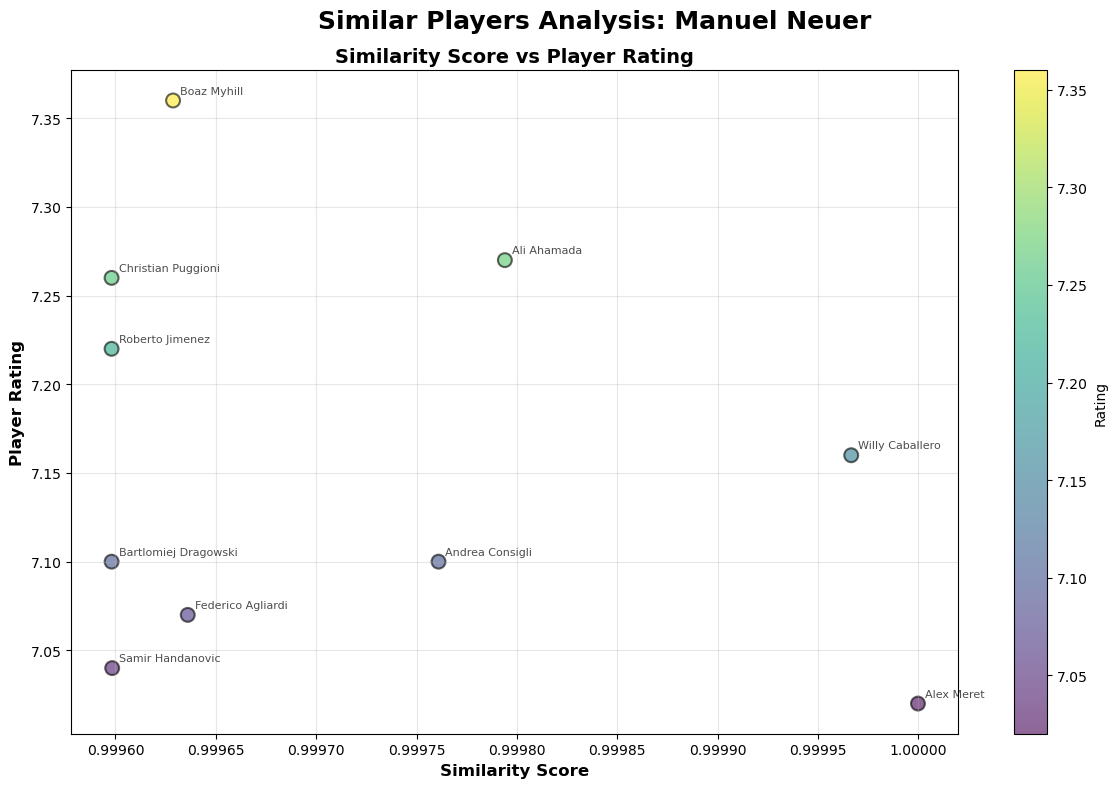

In [52]:
player_name = "Manuel Neuer" 
n_similar = 10
similar_players = display_similar_players(
    player_name, 
    n_similar=n_similar, 
    show_performance=True, 
    show_graph=True,
    lsh=lsh_index,
    minhash_list=minhash_list,
    X_data=X_full_scaled,
    df_data=df_full,
    player_name_to_idx_map=player_name_to_idx)